# Imports

In [24]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn.decomposition
import sklearn.model_selection
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU enable')
    except Exception as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU enable


# Data

Load and prepare your dataset. Dataset should have at least 10k samples in it. Each dataset cannot be used by more than two students.

In [ ]:
root_path = 'cats_and_dogs'
deleted = []
for animal in ['Cat', 'Dog']:
  for filename in os.listdir(f'{root_path}/{animal}'):
    file = f'{root_path}/{animal}/{filename}'
    try:
      img_bytes = tf.io.read_file(file)
      decoded_img = tf.io.decode_image(img_bytes)
    except tf.errors.InvalidArgumentError:
      deleted.append(file)
      os.remove(file)

In [4]:
deleted

['cats_and_dogs/Dog/9500.jpg']

In [2]:
def get_pd_from_paths(path_to_files: str, assigned_class: int) -> pd.DataFrame:
    images_paths = []
    filelist = os.listdir(path_to_files)

    for file in filelist:
        file_path = os.path.join(path_to_files, file)
        images_paths.append(file_path)

    return pd.DataFrame(
        list(zip(images_paths, [assigned_class] * len(images_paths))),
        columns=['filepaths', 'class_id']
        )

In [3]:
cats = 'cats_and_dogs\Cat', 0
dogs = 'cats_and_dogs\Dog', 1

In [4]:
data = pd.concat(
    [
        get_pd_from_paths(*cats),
        get_pd_from_paths(*dogs)
    ],
    axis=0,
    ignore_index=True
)

In [5]:
data

,filepaths,class_id
0,cats_and_dogs\Cat\0.jpg,0
1,cats_and_dogs\Cat\1.jpg,0
2,cats_and_dogs\Cat\10.jpg,0
3,cats_and_dogs\Cat\100.jpg,0
4,cats_and_dogs\Cat\1000.jpg,0
...,...,...
24986,cats_and_dogs\Dog\9995.jpg,1
24987,cats_and_dogs\Dog\9996.jpg,1
24988,cats_and_dogs\Dog\9997.jpg,1
24989,cats_and_dogs\Dog\9998.jpg,1


In [6]:
paths_dataset = tf.data.Dataset.from_tensor_slices(data.filepaths)

In [7]:
image_dataset = paths_dataset.map(lambda x: tf.image.resize(tf.io.decode_image(tf.io.read_file(x), expand_animations=False, channels=3), [640, 640], method='lanczos5'))

In [8]:
batch_image_dataset = image_dataset.batch(64)

# Backbone

Load pretrained model from Hugging Face (or some other model repository if it's more convenient). Model should be trained on Feature Extraction task.

In [9]:
backbone = transformers.AutoModel.from_pretrained('facebook/dinov2-base').cuda()

Load tokenizer to be used with the model

In [10]:
processor = transformers.AutoImageProcessor.from_pretrained('facebook/dinov2-base')

# Feature extraction

Since we will not be training the backbone, extract features from your dataset.

Run the backbone on the images and save the extracted features. Don't forget to process the images. Images don't have to be of the same size, though it would be faster if they were. If the images don't fit in memory, lazily load them from disk

In [ ]:
features = []
with torch.no_grad():
    for img in tqdm.tqdm(image_dataset):
        img = processor(img.numpy().astype(np.uint8), return_tensors='pt')['pixel_values'].cuda()
        features.extend(backbone(img).pooler_output.cpu().numpy())

features = np.array(features)

np.save('features.npy', features)

In [11]:
features = np.load('features.npy')

In [12]:
features.shape

(24991, 768)

# Prepare train/test data

Split your data (extracted features and labels) into train and test subsets.

In [13]:
y = np.array(data.class_id)

In [14]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features, y)

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [15]:
train_X = tf.data.Dataset.from_tensor_slices(X_train)
train_y = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_X, train_y)).batch(128)

test_X = tf.data.Dataset.from_tensor_slices(X_test)
test_y = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_X, test_y)).batch(128)

# Build the model

Build a simple model. The model should accept an extracted feature vector and return a vector of class logits (or probabilities). Model should only have a couple (or even 1) layers with weights.

In [16]:
inputs = tf.keras.layers.Input(768, name='input', dtype=tf.float32)
x = tf.keras.layers.Dense(256, name='pre-prediction')(inputs)
x = tf.keras.layers.Dense(1, name='prediction')(x)
model = tf.keras.Model(inputs=inputs, outputs=x, name='craft')

Compile the model. Choose loss and metrics.

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics='accuracy')

# Train the model

In [18]:
model.fit(train_dataset, validation_data=test_dataset, epochs=6)

Epoch 1/6
147/147 [==============================] - 5s 11ms/step - loss: 0.0339 - accuracy: 0.9916 - val_loss: 0.0152 - val_accuracy: 0.9974
Epoch 2/6
147/147 [==============================] - 1s 10ms/step - loss: 0.0089 - accuracy: 0.9980 - val_loss: 0.0142 - val_accuracy: 0.9982
Epoch 3/6
147/147 [==============================] - 1s 10ms/step - loss: 0.0053 - accuracy: 0.9986 - val_loss: 0.0153 - val_accuracy: 0.9974
Epoch 4/6
147/147 [==============================] - 1s 10ms/step - loss: 0.0013 - accuracy: 0.9994 - val_loss: 0.0143 - val_accuracy: 0.9982
Epoch 5/6
147/147 [==============================] - 1s 10ms/step - loss: 8.6038e-04 - accuracy: 0.9996 - val_loss: 0.0147 - val_accuracy: 0.9981
Epoch 6/6
147/147 [==============================] - 1s 10ms/step - loss: 0.0025 - accuracy: 0.9991 - val_loss: 0.0161 - val_accuracy: 0.9979


# Evaluation

Evalute the model on test data.

In [19]:
model.evaluate(X_test, y_test, batch_size=128)

49/49 [==============================] - 0s 5ms/step - loss: 0.0161 - accuracy: 0.9979


[0.01612664759159088, 0.9979193210601807]

Plot confusion matrix.

196/196 [==============================] - 0s 2ms/step


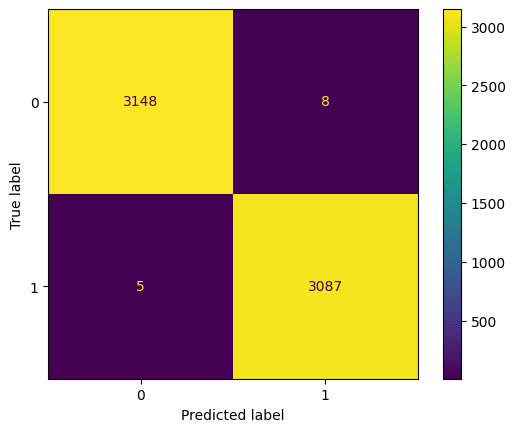

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test, model.predict(X_test) > 0.5)

Perform dimensiality reduction and plot the extracted features. Do classes form clusters?

In [21]:
def scale(data):
    return np.array([
        (i - data.min()) / (data.max() - data.min())
        for i in data
    ])

In [22]:
def plot_thing(data: pd.DataFrame, processor, backbone, n_classes: int, n_images_per_class: int, threshold: float = 1, batch_size: int = 8, image_size: int = 640, use_tsne: bool = True):
    rng = np.random.default_rng()

    old_image_size = processor.size['shortest_edge']
    processor.crop_size['height'] = processor.crop_size['width'] = image_size
    processor.size['shortest_edge'] = image_size

    classes = rng.choice(data.class_id.unique(), replace=False, size=n_classes)
    images = []
    for i in classes:
        for j in rng.choice(data.filepaths[data.class_id == i], size=n_images_per_class, replace=False):
            images.append(cv2.cvtColor(cv2.imread(j), cv2.COLOR_BGR2RGB))

    img = processor(images, return_tensors='pt')
    img = img['pixel_values'].cuda()

    with torch.no_grad():
        n_batches = (img.shape[0] + batch_size - 1) // batch_size
        features = np.concatenate([backbone(img[i * batch_size:(i + 1) * batch_size]).last_hidden_state.cpu().numpy()[:, 1:] for i in tqdm.trange(n_batches)], axis=0)

    del img

    n = int(np.sqrt(features.shape[1]))

    if use_tsne:
        features = scale(sklearn.manifold.TSNE(n_components=3).fit_transform(features.reshape(-1, features.shape[-1])).reshape(-1, n, n, 3))
    else:
        features = scale(sklearn.decomposition.PCA(n_components=3).fit_transform(features.reshape(-1, features.shape[-1])).reshape(-1, n, n, 3))

    processor.do_rescale = False
    processor.do_normalize = False
    images = processor(images=images, return_tensors='np')['pixel_values'].transpose(0, 2, 3, 1)
    processor.do_rescale = True
    processor.do_normalize = True

    processor.crop_size['height'] = processor.crop_size['width'] = old_image_size
    processor.size['shortest_edge'] = old_image_size

    _, ax = plt.subplots(ncols=n_classes * 2, nrows=n_images_per_class, figsize=(10 * n_classes, 5 * n_images_per_class))
    
    mask = features[..., 0] <= threshold
    features = np.where(mask[..., None], features, 0.)

    features = features.reshape(n_classes, n_images_per_class, n, n, 3)
    images = images.reshape(n_classes, n_images_per_class, *images.shape[1:3], 3)

    for i in range(n_classes):
        for j in range(n_images_per_class):
            ax[j, 2 * i].imshow(images[i, j])
            ax[j, 2 * i].axis('off')
            
            ax[j, 2 * i + 1].imshow(features[i, j])
            ax[j, 2 * i + 1].axis('off')

        ax[0, 2 * i].set_title(classes[i])

    plt.tight_layout()

  0%|          | 0/2 [00:00<?, ?it/s]

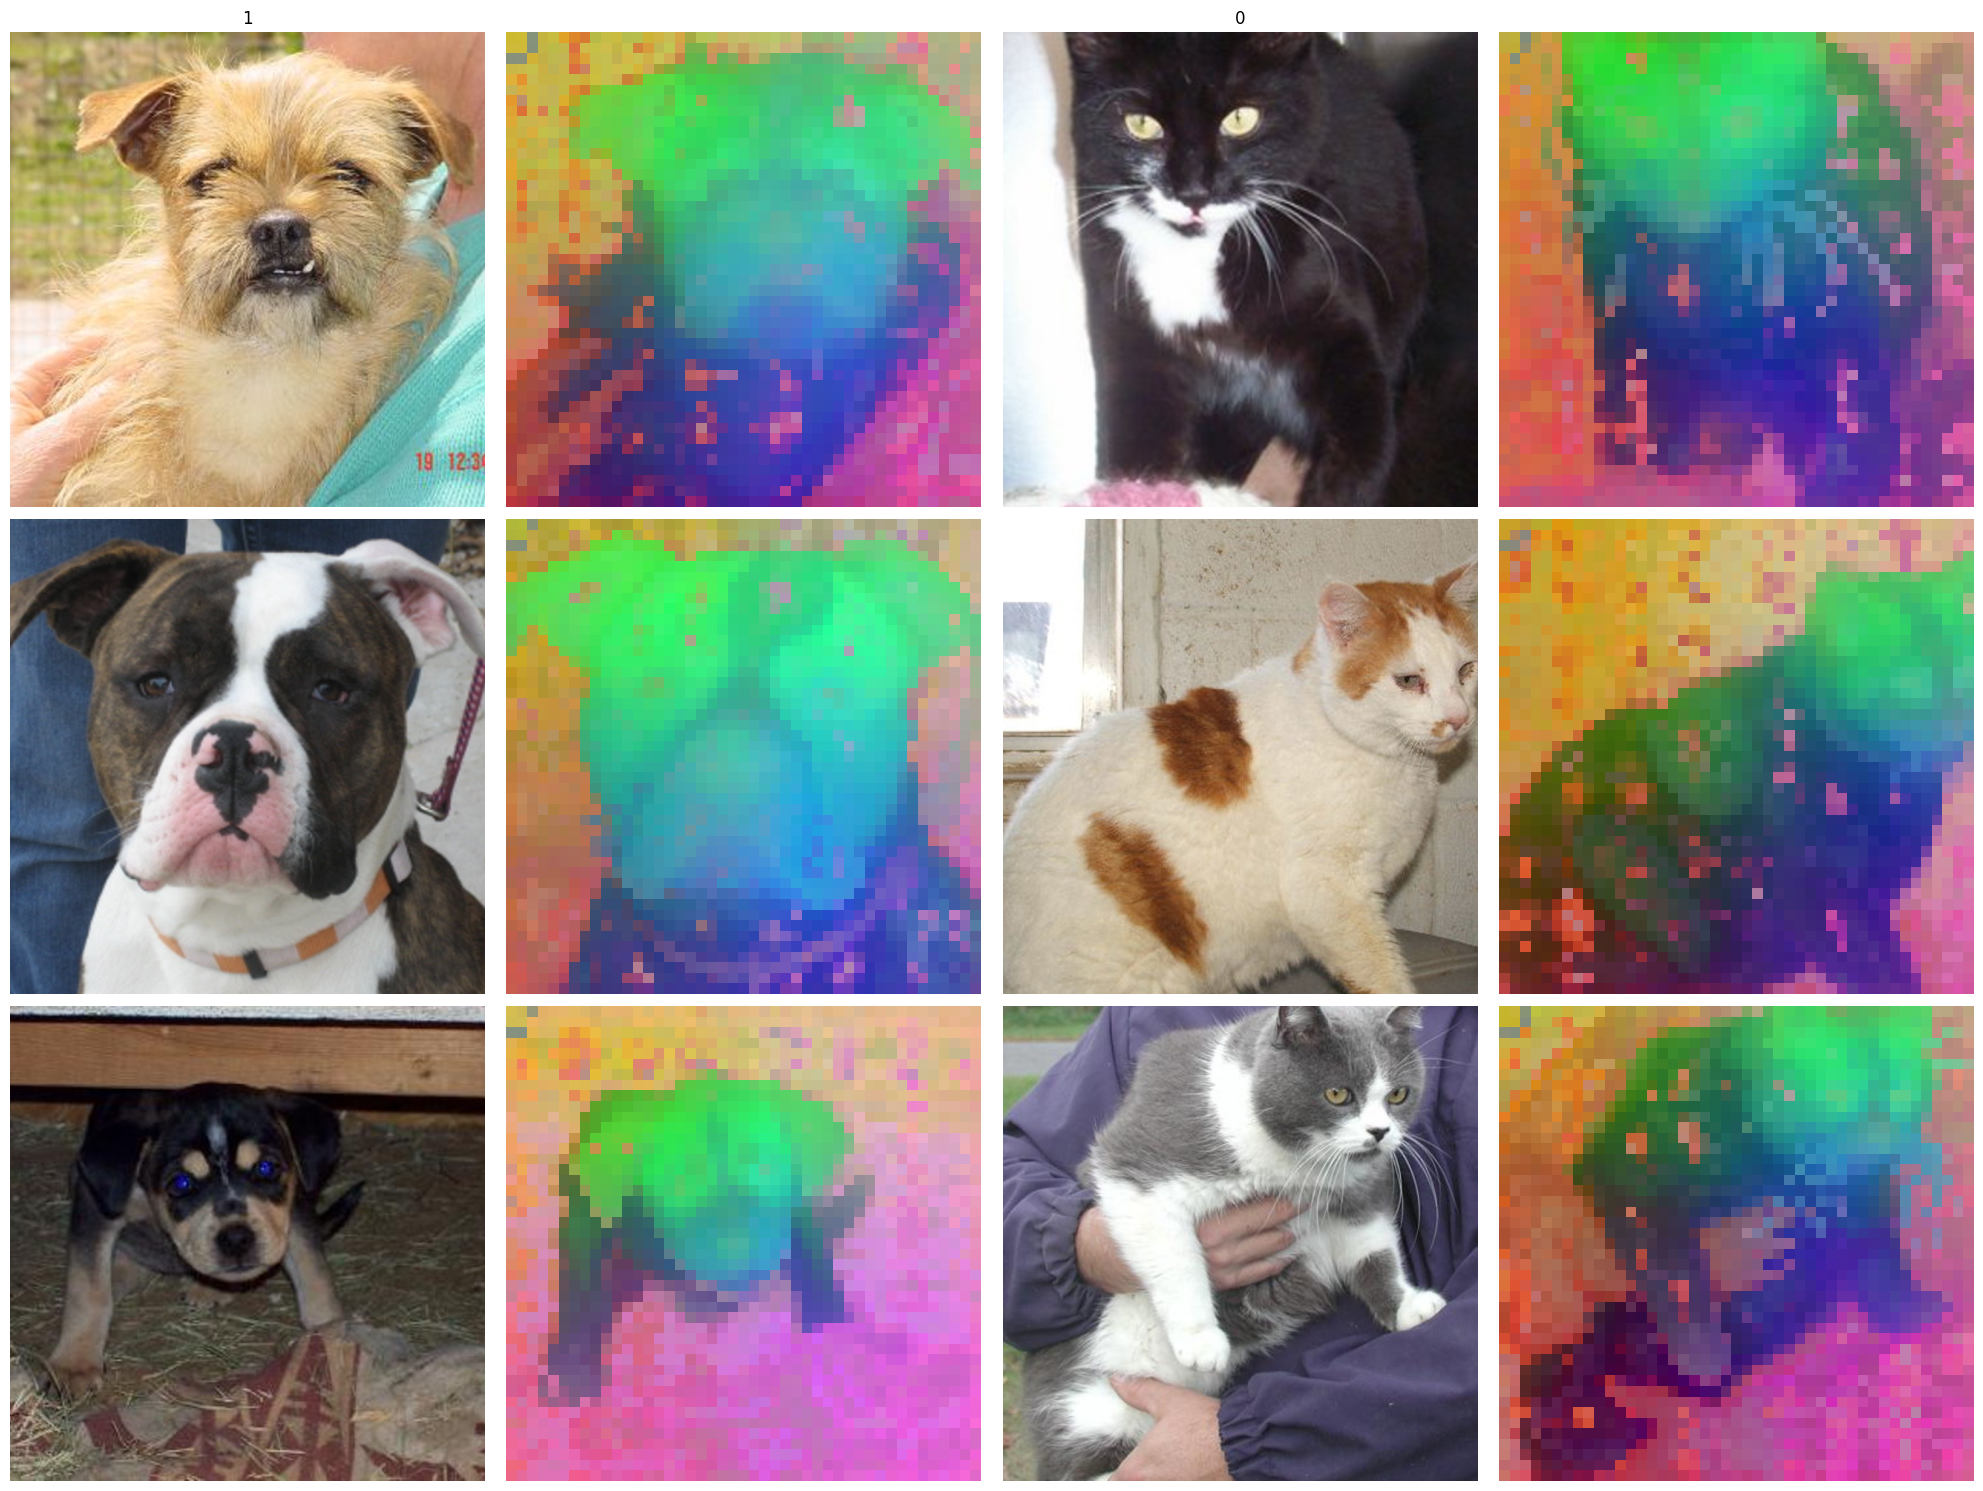

In [26]:
plot_thing(data, processor, backbone, 2, 3, threshold=1, batch_size=4, image_size=640, use_tsne=False)